In [9]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt

In [10]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [11]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

acciona_ene = df[df['empresa'] == 'Acciona Energia']

acciona_ene.shape

(684, 10)

In [12]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

acciona_ene = acciona_ene [['date','open','high','low','close','adj close']]

acciona_ene.shape

(684, 6)

In [13]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

acciona_ene['date'] = pd.to_datetime(acciona_ene['date'], format="%Y-%m-%d")

acciona_ene.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, 1316 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       684 non-null    datetime64[ns]
 1   open       684 non-null    float64       
 2   high       684 non-null    float64       
 3   low        684 non-null    float64       
 4   close      684 non-null    float64       
 5   adj close  684 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 37.4 KB


In [14]:
# Paso 5: Ordenar el DF por fecha

acciona_ene.sort_values(by='date',ascending= True, inplace=True)

acciona_ene.head()

,date,open,high,low,close,adj close
1534,2021-07-05,29.500000,29.50,28.549999,29.000000,28.145775
1533,2021-07-06,29.100000,29.10,28.500000,28.790001,27.941961
1532,2021-07-07,28.790001,29.50,28.520000,29.500000,28.631046
1531,2021-07-08,29.480000,29.90,29.059999,29.900000,29.019264
1530,2021-07-09,29.950001,30.75,29.629999,30.600000,29.698645


In [15]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

acciona_ene = acciona_ene[(acciona_ene['date'] >= fecha_inicio) & (acciona_ene['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

acciona_ene.shape

(684, 6)

In [16]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=acciona_ene['date'].min(), end=acciona_ene['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

acciona_ene = acciona_ene.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

acciona_ene = acciona_ene.rename(columns={'index': 'date'})

acciona_ene = acciona_ene.fillna(method='ffill')

In [17]:
# Paso 8: Transformar serie temporal en ramdon forest

acciona_rfr = acciona_ene[['date','close']]

acciona_rfr

,date,close
0,2021-07-05,29.000000
1,2021-07-06,28.790001
2,2021-07-07,29.500000
3,2021-07-08,29.900000
4,2021-07-09,30.600000
...,...,...
966,2024-02-26,19.690001
967,2024-02-27,19.969999
968,2024-02-28,19.559999
969,2024-02-29,19.100000


In [18]:
acciona_rfr.close = acciona_rfr.close.round(2)

acciona_rfr

,date,close
0,2021-07-05,29.00
1,2021-07-06,28.79
2,2021-07-07,29.50
3,2021-07-08,29.90
4,2021-07-09,30.60
...,...,...
966,2024-02-26,19.69
967,2024-02-27,19.97
968,2024-02-28,19.56
969,2024-02-29,19.10


In [19]:
new_df = pd.DataFrame(columns=['d-4', 'd-3', 'd-2', 'd-1', 'do'])

new_df

,d-4,d-3,d-2,d-1,do


In [20]:
for i in range(len(new_df.columns)):
    new_df[new_df.columns[i]] = acciona_rfr['close'].shift(-i)

In [21]:
new_df

,d-4,d-3,d-2,d-1,do
0,29.00,28.79,29.50,29.90,30.60
1,28.79,29.50,29.90,30.60,30.60
2,29.50,29.90,30.60,30.60,30.60
3,29.90,30.60,30.60,30.60,30.54
4,30.60,30.60,30.60,30.54,30.45
...,...,...,...,...,...
966,19.69,19.97,19.56,19.10,19.79
967,19.97,19.56,19.10,19.79,NaN
968,19.56,19.10,19.79,NaN,NaN
969,19.10,19.79,NaN,NaN,NaN


In [22]:
new_df.dropna(axis=0,inplace=True)

In [23]:
new_df

,d-4,d-3,d-2,d-1,do
0,29.00,28.79,29.50,29.90,30.60
1,28.79,29.50,29.90,30.60,30.60
2,29.50,29.90,30.60,30.60,30.60
3,29.90,30.60,30.60,30.60,30.54
4,30.60,30.60,30.60,30.54,30.45
...,...,...,...,...,...
962,20.28,19.78,19.78,19.78,19.69
963,19.78,19.78,19.78,19.69,19.97
964,19.78,19.78,19.69,19.97,19.56
965,19.78,19.69,19.97,19.56,19.10


In [24]:
from sklearn.ensemble import RandomForestRegressor as RFR 

rfr=RFR()

In [25]:
# Paso : Separar X e y para los modelos

X = new_df.drop('do',axis=1)

y = new_df.do 

In [26]:
from sklearn.model_selection import train_test_split as tts   


X_train, X_test, y_train, y_test = tts(X, y,
                                       train_size=0.8,
                                       test_size=0.2,
                                       random_state=42
                                      )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((773, 4), (194, 4), (773,), (194,))

In [27]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [28]:
rfr.predict(X_test)[:10]

array([31.0567, 37.199 , 25.2684, 37.4982, 29.0094, 35.465 , 24.0006,
       27.1461, 27.7361, 32.5537])

In [29]:
from sklearn.metrics import mean_squared_error as mse  # error cuadratico medio


y_pred=rfr.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

0.49267611040030634

In [30]:
%pip install lazypredict


Note: you may need to restart the kernel to use updated packages.


In [58]:
from lazypredict.Supervised import LazyRegressor

# Initialize Lazy Regressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# Fit and score all models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

pd.options.display.max_rows=100

import lightgbm as lgb

params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,}
    # Otros parámetros

100%|██████████| 42/42 [00:02<00:00, 14.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 4
[LightGBM] [Info] Start training from score 32.119987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [32]:
from sklearn.linear_model import OrthogonalMatchingPursuit as OMP

omp= OMP()


In [33]:
omp.fit(X_train, y_train)

OrthogonalMatchingPursuit()

In [34]:
omp.predict(X_test)[:10]

array([31.64755612, 36.96453926, 25.21540049, 37.80091863, 29.04880593,
       35.51083226, 24.17988317, 26.94790061, 28.15268518, 32.38436652])

In [35]:
y_pred=omp.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

0.4079284896271253

In [36]:
new_df_1 = new_df[['d-4','d-3','d-2','d-1']]

new_df_1

,d-4,d-3,d-2,d-1
0,29.00,28.79,29.50,29.90
1,28.79,29.50,29.90,30.60
2,29.50,29.90,30.60,30.60
3,29.90,30.60,30.60,30.60
4,30.60,30.60,30.60,30.54
...,...,...,...,...
962,20.28,19.78,19.78,19.78
963,19.78,19.78,19.78,19.69
964,19.78,19.78,19.69,19.97
965,19.78,19.69,19.97,19.56


In [37]:
y_pred=omp.predict(new_df_1)

pred = pd.DataFrame(y_pred)

pred

,0
0,29.90
1,30.59
2,30.59
3,30.59
4,30.53
...,...
962,19.82
963,19.73
964,20.01
965,19.60


In [38]:
new_df['pred'] = pred

In [39]:
new_df

,d-4,d-3,d-2,d-1,do,pred
0,29.00,28.79,29.50,29.90,30.60,29.90
1,28.79,29.50,29.90,30.60,30.60,30.59
2,29.50,29.90,30.60,30.60,30.60,30.59
3,29.90,30.60,30.60,30.60,30.54,30.59
4,30.60,30.60,30.60,30.54,30.45,30.53
...,...,...,...,...,...,...
962,20.28,19.78,19.78,19.78,19.69,19.82
963,19.78,19.78,19.78,19.69,19.97,19.73
964,19.78,19.78,19.69,19.97,19.56,20.01
965,19.78,19.69,19.97,19.56,19.10,19.60


In [40]:
new_df.rename(columns={'do': 'real'}, inplace=True)



In [41]:
new_df['error'] = new_df.pred - new_df.real

new_df

,d-4,d-3,d-2,d-1,real,pred,error
0,29.00,28.79,29.50,29.90,30.60,29.90,-0.70
1,28.79,29.50,29.90,30.60,30.60,30.59,-0.01
2,29.50,29.90,30.60,30.60,30.60,30.59,-0.01
3,29.90,30.60,30.60,30.60,30.54,30.59,0.05
4,30.60,30.60,30.60,30.54,30.45,30.53,0.08
...,...,...,...,...,...,...,...
962,20.28,19.78,19.78,19.78,19.69,19.82,0.13
963,19.78,19.78,19.78,19.69,19.97,19.73,-0.24
964,19.78,19.78,19.69,19.97,19.56,20.01,0.45
965,19.78,19.69,19.97,19.56,19.10,19.60,0.50


In [42]:
acciona_rfr

,date,close
0,2021-07-05,29.00
1,2021-07-06,28.79
2,2021-07-07,29.50
3,2021-07-08,29.90
4,2021-07-09,30.60
...,...,...
966,2024-02-26,19.69
967,2024-02-27,19.97
968,2024-02-28,19.56
969,2024-02-29,19.10


In [59]:
inicio_indice = 0
fin_indice = 970
acciona_rfr = acciona_rfr.loc[inicio_indice:fin_indice]

In [60]:
acciona_rfr

,date,close
0,2021-07-05,29.00
1,2021-07-06,28.79
2,2021-07-07,29.50
3,2021-07-08,29.90
4,2021-07-09,30.60
...,...,...
966,2024-02-26,19.69
967,2024-02-27,19.97
968,2024-02-28,19.56
969,2024-02-29,19.10


In [45]:
new_df['date'] = acciona_rfr.date


In [46]:
new_df

,d-4,d-3,d-2,d-1,real,pred,error,date
0,29.00,28.79,29.50,29.90,30.60,29.90,-0.70,2021-07-05
1,28.79,29.50,29.90,30.60,30.60,30.59,-0.01,2021-07-06
2,29.50,29.90,30.60,30.60,30.60,30.59,-0.01,2021-07-07
3,29.90,30.60,30.60,30.60,30.54,30.59,0.05,2021-07-08
4,30.60,30.60,30.60,30.54,30.45,30.53,0.08,2021-07-09
...,...,...,...,...,...,...,...,...
962,20.28,19.78,19.78,19.78,19.69,19.82,0.13,2024-02-22
963,19.78,19.78,19.78,19.69,19.97,19.73,-0.24,2024-02-23
964,19.78,19.78,19.69,19.97,19.56,20.01,0.45,2024-02-24
965,19.78,19.69,19.97,19.56,19.10,19.60,0.50,2024-02-25


In [47]:
new_df.insert(0, 'date', new_df.pop('date'))

In [48]:
new_df

,date,d-4,d-3,d-2,d-1,real,pred,error
0,2021-07-05,29.00,28.79,29.50,29.90,30.60,29.90,-0.70
1,2021-07-06,28.79,29.50,29.90,30.60,30.60,30.59,-0.01
2,2021-07-07,29.50,29.90,30.60,30.60,30.60,30.59,-0.01
3,2021-07-08,29.90,30.60,30.60,30.60,30.54,30.59,0.05
4,2021-07-09,30.60,30.60,30.60,30.54,30.45,30.53,0.08
...,...,...,...,...,...,...,...,...
962,2024-02-22,20.28,19.78,19.78,19.78,19.69,19.82,0.13
963,2024-02-23,19.78,19.78,19.78,19.69,19.97,19.73,-0.24
964,2024-02-24,19.78,19.78,19.69,19.97,19.56,20.01,0.45
965,2024-02-25,19.78,19.69,19.97,19.56,19.10,19.60,0.50


In [49]:
import matplotlib.pyplot as plt

In [50]:
new_df.error = new_df.error.astype(int)

In [51]:
new_df

,date,d-4,d-3,d-2,d-1,real,pred,error
0,2021-07-05,29.00,28.79,29.50,29.90,30.60,29.90,0
1,2021-07-06,28.79,29.50,29.90,30.60,30.60,30.59,0
2,2021-07-07,29.50,29.90,30.60,30.60,30.60,30.59,0
3,2021-07-08,29.90,30.60,30.60,30.60,30.54,30.59,0
4,2021-07-09,30.60,30.60,30.60,30.54,30.45,30.53,0
...,...,...,...,...,...,...,...,...
962,2024-02-22,20.28,19.78,19.78,19.78,19.69,19.82,0
963,2024-02-23,19.78,19.78,19.78,19.69,19.97,19.73,0
964,2024-02-24,19.78,19.78,19.69,19.97,19.56,20.01,0
965,2024-02-25,19.78,19.69,19.97,19.56,19.10,19.60,0


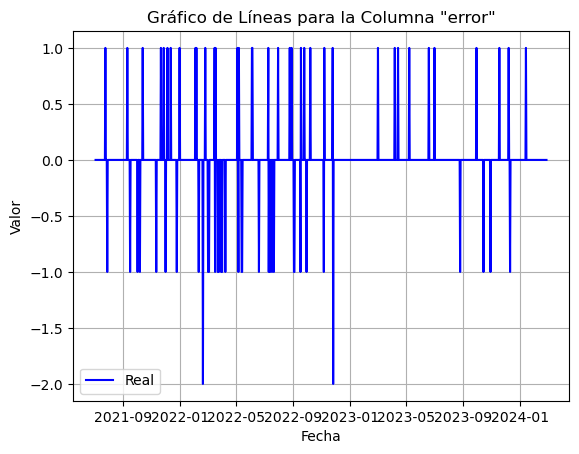

In [52]:
error_data = new_df['error']


# Crear un gráfico de líneas
plt.plot(new_df['date'], error_data, marker='None', linestyle='-', color='b', label='Real')

# Configuración del gráfico
plt.title('Gráfico de Líneas para la Columna "error"')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
condiciones = [
    (new_df['error'] == 0),
    (new_df['error'] >= 1),
    (new_df['error'] <= -1)
]

categorias = [0, 1, 2]

new_df['cate'] = np.select(condiciones, categorias, default=None)

In [54]:
new_df

,date,d-4,d-3,d-2,d-1,real,pred,error,cate
0,2021-07-05,29.00,28.79,29.50,29.90,30.60,29.90,0,0
1,2021-07-06,28.79,29.50,29.90,30.60,30.60,30.59,0,0
2,2021-07-07,29.50,29.90,30.60,30.60,30.60,30.59,0,0
3,2021-07-08,29.90,30.60,30.60,30.60,30.54,30.59,0,0
4,2021-07-09,30.60,30.60,30.60,30.54,30.45,30.53,0,0
...,...,...,...,...,...,...,...,...,...
962,2024-02-22,20.28,19.78,19.78,19.78,19.69,19.82,0,0
963,2024-02-23,19.78,19.78,19.78,19.69,19.97,19.73,0,0
964,2024-02-24,19.78,19.78,19.69,19.97,19.56,20.01,0,0
965,2024-02-25,19.78,19.69,19.97,19.56,19.10,19.60,0,0


In [55]:
catg = new_df[['date','d-4','d-3','d-2','d-1','real','cate']]

In [56]:
catg.to_csv('acciona_class.csv',index=False)